# Sampling pi

Notebook written by [Manon Michel](manon.michel@uca.fr)

The beginning of stochastic computation takes place in the XVIIIth century with Buffon’s needle problem, the earliest problem of geometric probability. In 1733, the French naturalist asked the question of determining the probability that a needle of a certain length will lend on a line of the parquet flooring, made of equally spaced and parallel planks (1, p. 43- 45) and solved it in 1777 (2, p. 100 - 104). Even if it was not Buffon’s prime interest, the needle problem can be considered as the first Monte Carlo computation of the number $\pi$, by dropping needles on the parquet flooring and counting how many intersect a line of the floor.

![](buffon_start.png)

The goal here is to recreate the Buffon needle's game and to come up with a better sampling of $\pi$.

Refs:

(1) Buffon. [Histoire de l’Académie Royale des Sciences](http://gallica.bnf.fr/ark:/12148/bpt6k3530m/f51.image.r=). Imprimerie royale (Paris), 1733.

(2) G.-L. Leclerc comte de Buffon. [Histoire Naturelle, Générale et Particulière : supplément](http://www.buffon.cnrs.fr/ice/ice_page_detail.php?lang=fr&type=text&bdd=buffon&table=buffon_hn&bookId=33&typeofbookDes=hns&pageChapter=&pageOrder=104&facsimile=off&search=no). Tome Quatrième. Imprimerie royale (Paris), 1777.


Find below the animation of the simulation to recreate.

<video width="980 " height=" " 
       src="Buffon.mp4"  
       controls>
</video>

Library importation

In [1]:
import numpy as np
import random, math
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
from matplotlib.ticker import FixedLocator

plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 8

Below, please:
1. Write the routine `add_needle` for the random needle throw.
2. What is the impact of the value of the r parameter?
3. Analytically derive the probability of a needle throw hitting two planks (r < 1 case)
4. What is the average value of the observable $\theta$ which is equal to $1$ when a needle hits two planks and $0$ otherwise?
5. Write the routine `get_running_pi` to estimate $\pi$ from the first `n_throws` samples (`n_throws` being a number)
6. Write the routine `generate_throws` to generate $N$ samples and print the estimated value of $\pi$

## Solution to written exercises 

### Exercise 2

The impact of the parameter $r$ is to determine the intersection conditions. If $r \geq 0$ we may have intersections on two different planks at the same time, whereas if $r < 0$ that is not possible. 

### Exercise 3

Without loss of generality, we consider the problem where the needle is thrown only between two lines. Under the condition of $r < 1$, we reach the lines either with the bottom half of the needle or with its upper half.

- To touch the left line we must have $x - \frac{l}{2}\cos(\theta) \leq 0$.

- To touch the upper half we must have $x + \frac{l}{2}\cos(\theta) \geq d$

As these two conditions are independant we may compute their probability independently and add up at the end.

The problem is clearly independent of the coordinate $y$. We will assume that $X \sim \text{U}(0,d)$ and $\Theta \sim \text{U}(0,\frac{\pi}{2})$ (we have symmetry for $\theta$). Therefore our probability of touching one of the lines is:

$$
P = P_{l} + P_{r}
$$

With

$$
P_{l} = \frac{2}{d\pi} \int_{0}^{d}\int_{0}^{\frac{\pi}{2}} 1_{x - l\frac{l}{2}\cos(\theta) \leq 0} \, dx d\theta
$$

$$
P_{l} = \frac{2}{d\pi} \int_{0}^{\frac{\pi}{2}}\int_{0}^{l\frac{l}{2}\cos(\theta)} \, dx d\theta
$$

$$
P_{l} = \frac{l}{d\pi} \int_{0}^{\frac{\pi}{2}} \cos(\theta) d\theta
$$

$$
P_{l} = \frac{l}{d\pi} 
$$

Similarly:

$$
P_r = \frac{2}{d\pi} \int_{0}^{d}\int_{0}^{\frac{\pi}{2}} 1_{x + \frac{l}{2}\cos(\theta) \geq d} \, dx d\theta
$$

$$
P_r = \frac{2}{d\pi} \int_{0}^{\frac{\pi}{2}} \int_{d-\frac{l}{2}\cos(\theta)}^{d} \, dx d\theta
$$

$$
P_r = \frac{l}{d\pi} \int_{0}^{\frac{\pi}{2}} \cos(\theta) \, d\theta
$$

$$
P_r = \frac{l}{d\pi}
$$

Therefore we concluded that the probability $P$ is:

$$
P = P_{l} + P_{r} = \frac{2l}{d\pi}
$$

### Exercise 4

The observable is nothing less than the estimator of the probability of hitting a line (two planks). Therefore we should expect that it will converge to the probability as long as we have sufficient observations. Hence, by the law of large numbers its expected value is $\frac{2l}{d\pi}$.

In [2]:
class buffon_exp:
    def __init__(self):
        # Parameter initialization
        self.l = 0.33 # needle length
        self.d = 1.0 # plank width
        self.r = self.l / self.d 
        self.N = 1000 # Number of needle throws
        self.start = self.N + 1 # number of first plank-hitting needle (
                                #(initialized to a value bigger than self.N)
        self.nx = 10 # Number of planks
        self.ny = 5 # self.d * self.ny = height of a plank
        self.Lx = [i * self.d for i in range(self.nx)]
        self.data = [] # Store whether a throw is hitting two planks or not
        self.C = [] # Store thrown needle positions. A needle configuration
                    # is completely determined by thre triplet (x, y, phi)
                    # x, y = needle center position and phi = needle angle

    def add_needle(self):
        # Write a routine randomly throwing a needle and 
        # checking whether the throw hit two planks 

        # Generating throw and storing the information
        x = np.random.uniform(0,self.nx*self.d)
        y = np.random.uniform(0, self.ny)
        theta = np.random.uniform(0, np.pi/2)

        self.C.append((x,y,theta))

        # Adjusting to the position relative to the plank
        x %= self.d

        touch = 0
        # Condition for touching the bottom
        if x >= self.d - self.l*np.cos(theta)/2 or x <= self.l * np.cos(theta) / 2: 
            touch = 1

        self.data.append(touch)
        
    def estimate_pi(self, n_throws):
        # Write a routine to estimate pi from the first `n_throws` samples

        if n_throws > self.start:
            return 2 * self.l / (self.d * sum(self.data[:n_throws]) / n_throws)
        
    def generate_throws(self):
        # Write a routine to generate self.N needle throw and compute the estimated pi
        
        print("Generating needle throws")

        for i in range(self.N):
            self.add_needle()
            if self.data[-1] == 1: 
                self.start = min(self.start, i+1)

        print(f"hat_pi = {self.estimate_pi(self.N)} for {self.N} throws")

        return self.estimate_pi(self.N)

        
    def plot_error(self, **kwargs):
        # Complete the routine to plot the error between the estimated pi and its true value.
        if 'fig' in kwargs:
            fig_err = kwargs['fig']
        else:
            fig_err = plt.fig(figsize=(9,5))
        if 'color' in kwargs:
            color =  kwargs['color']
        else:
            color = random.choice(['k','b','y','r','chartreuse','magenta'])
        if 'alpha' in kwargs:
            alpha = kwargs['alpha']
        else:
            alpha = 1.0
        ax = fig_err.gca()
        ax.plot(np.array([float(len(self.data[:(i)])) for i in range(self.start+1, self.N)]), 
                np.array([self.estimate_pi(i) - np.pi for i in range(self.start+1, self.N)]),
                 lw=1.5, c = color, alpha = alpha)
            
    def set_fig(self):
        self.fig, self.axes=plt.subplots(1, 2, figsize = (9, 5))
        for i in range(self.nx+1):
            self.axes[0].axvline(x = i * self.d, c = 'k')
        self.axes[0].set_xticks([]);self.axes[0].xaxis.set_ticklabels([])
        self.axes[0].set_yticks([]);self.axes[0].yaxis.set_ticklabels([])
        self.axes[0].set_xlim(-self.d/2.0,self.nx * self.d + self.d/2.0)
        self.axes[0].set_ylim(-self.d/2.0, self.ny * self.d + self.d/2.0)
        self.axes[1].axhline(y=math.pi)
        self.axes[1].set_ylabel(r'$\hat{\pi}$', fontsize=10)
        self.axes[1].set_xlabel(r'$N$', fontsize=10)
        self.axes[1].set_xlim(0,self.N)
        self.axes[1].set_ylim(2.5,4)
    
    def plot_total(self):
        self.set_fig()
        for throw in range(self.N):                
            x, y, phi = self.C[throw]
            if self.data[throw] == 1:
                line = mlines.Line2D([x + self.l / 2.0 * math.cos(phi), x - self.l / 2.0 *math.cos(phi)], 
                                     [y + self.l / 2.0 * math.sin(phi), y - self.l / 2.0 *math.sin(phi)], 
                                     axes = self.axes[0], lw=2., c = 'r')
            else:
                line = mlines.Line2D([x + self.l / 2.0 * math.cos(phi), x - self.l / 2.0 *math.cos(phi)], 
                                     [y + self.l / 2.0 * math.sin(phi), y - self.l / 2.0 *math.sin(phi)], 
                                     axes = self.axes[0], lw=2., alpha = 0.1, c = 'k')
            self.axes[0].add_line(line)
        if self.start < self.N:
            self.axes[1].plot(np.array([float(len(self.data[:(i)])) for i in range(self.N)]), 
                              np.array([self.estimate_pi(i) for i in range(self.N)]),
                              lw=1.5, c = 'k')    
        plt.show()


Generating needle throws
hat_pi = 3.251231527093596 for 1000 throws


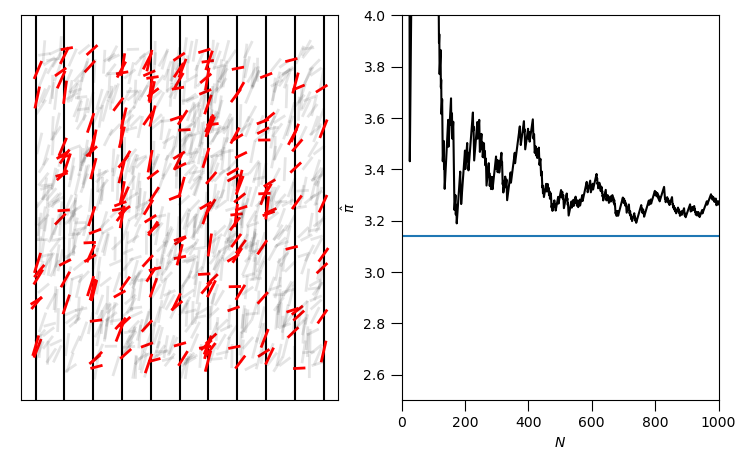

In [3]:
run_buffon = buffon_exp()
run_buffon.generate_throws()
run_buffon.plot_total()

7. How is the error between the estimator $\hat{\pi}$ and $\pi$ behaving with the number of samples $N$? Generate the error plot of 10 experiments. To do so, complete the `plot_error` routine above.



Generating needle throws
hat_pi = 3.0697674418604652 for 1000 throws
Generating needle throws
hat_pi = 3.127962085308057 for 1000 throws
Generating needle throws
hat_pi = 3.3 for 1000 throws
Generating needle throws
hat_pi = 3.1884057971014497 for 1000 throws
Generating needle throws
hat_pi = 3.1884057971014497 for 1000 throws
Generating needle throws
hat_pi = 2.7966101694915255 for 1000 throws
Generating needle throws
hat_pi = 3.267326732673267 for 1000 throws
Generating needle throws
hat_pi = 3.0841121495327104 for 1000 throws
Generating needle throws
hat_pi = 2.986425339366516 for 1000 throws
Generating needle throws
hat_pi = 3.2352941176470593 for 1000 throws


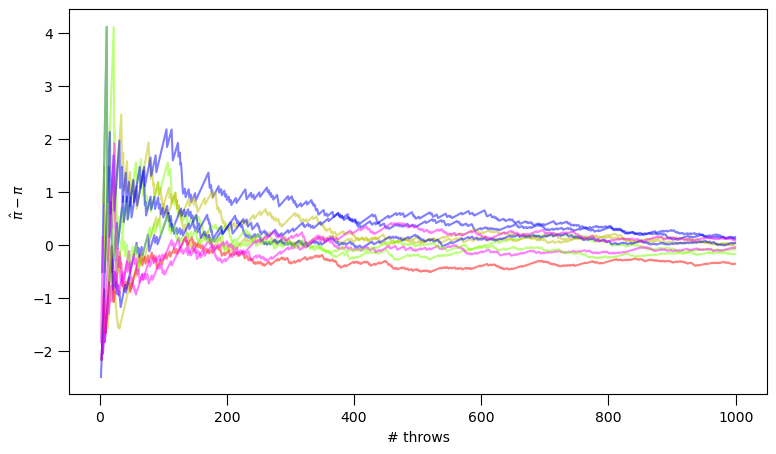

In [4]:
run_buffon = buffon_exp()
fig=plt.figure(figsize=(9,5))
for iter_experiment in range(10):
    run_buffon.generate_throws()
    run_buffon.plot_error(fig=fig, alpha = 0.5)
    run_buffon.C=[]
    run_buffon.data=[]
    run_buffon.start = run_buffon.N+1
plt.xlabel('# throws')
plt.ylabel(r'$\hat{\pi}-\pi$')
plt.show()

### Comment

We see that the error is converging to zero the more iterations we perform.

8. What is the variance of the estimator $\hat{\theta} = \frac{1}{N}\sum_{i=1}^N \theta_i$, $N$ being the number of throws?

9. Derive the variance of the estimator $\hat{\pi}$ you constructed


## Solution to exercises

### Exercise 8

The random variables $(\theta_{n})_{n\in\{1,\dots,N\}}$ are i.i.d, therefore we may compute the variace of $\hat{\theta}$ as follows:

$$
\text{Var}(\hat{\theta}) = \text{Var}\left( \frac{1}{N} \sum_{i = 1}^{N} \theta_{i} \right)
$$

$$
\text{Var}(\hat{\theta}) = \frac{N}{N^{2}} \text{Var} (\theta_{1}) 
$$

$$
\text{Var}(\hat{\theta}) = \frac{1}{N} \text{Var} (\theta_{1})
$$

Our $\theta_{1}$ is simply $1$ if the needle touches one of the lines, 0 otherwise. It is therefore a Bernouli random variable with $p = \frac{2l}{d\pi}$, hence $\text{Var}(\theta_{1}) = p(1-p)$, therefore:

$$
\text{Var}(\hat{\theta}) = \frac{1}{N} \frac{2l}{d\pi} \left(1 - \frac{2l}{d\pi}\right)
$$

### Exercise 9

We have that:

$$
\hat{\pi} = \frac{2l}{\hat{\theta}d}
$$

We can get the asymptotical variance of $\hat{\pi}$ by the delta method. We would then have:

$$
\text{Var}(\hat{\pi}) = \frac{1}{N} \frac{2l}{d} \left(1 - \frac{2l}{d\pi}\right) \left(\frac{1}{\mathbb{E}[\hat{\theta}]^2}\right)^2
$$

$$
\text{Var}(\hat{\pi}) = \frac{1}{N} \frac{2l}{d} \left(1 - \frac{2l}{d\pi}\right) \frac{d^{4}\pi^{4}}{16 l^{4}}
$$

$$
\text{Var}(\hat{\pi}) = \frac{1}{N} \left(1 - \frac{2l}{d\pi}\right) \frac{d^{3}\pi^{4}}{8 l^{3}}
$$

In order to construct an estimator of $\pi$ with a smaller variance, we now consider an experiment which will make the estimator $\hat{\pi}$ proportional to the averaged number of hits. 

We now throw pointwise pebbles in a unit square.
Below, please:

10. Write the routine `add_peeble` for the random peeble throw. What criterion should make a thrown peeble a successful hit?

11. Analytically derive the probability of a peeble throw to be successful

12. What is the average value of the observable $\theta$ which is equal to $1$ when a throw is successful and $0$ otherwise?

13. Write the routine `get_running_pi` to estimate $\pi$ from the first `n_throws` samples (`n_throws` being a number)

14. Write the routine `generate_throws` to generate $N$ samples and print the estimated value of $\pi$

## Solution to exercises

### Exercise 10

We only need to verify if the distance to the center of the peeble is smaller than the unit radius, hence if $x^{2} + y^{2} \leq R^{2}$. As the square is of composed by $\{(x,y), x\in[-0.5, 0.5] \text{ and } y\in[-0.5, 0.5]\}$ we have that $R = 0.5$ and thus $x^{2}+ y^{2} \leq 0.25$.

### Exercise 11

As we have an uniform distribution on the square, we have that the probability of a sucessful throw is the ratio between the area of the circle and the area of the square. We have that $S_{\text{circle}} = \frac{\pi}{4}$ and $S_{\text{square}} = 1$, hence :

$$
P = \frac{S_{circle}}{S_{square}} = \frac{\pi}{4}
$$

### Exercise 12

We have that $\theta \sim \text{Ber}(\frac{\pi}{4})$, as it is 1 one the peeble hits the circle, 0 otherwise. Therefore its expected value is $\frac{\pi}{4}$.

In [5]:
class peeble_exp:
    def __init__(self):
        self.data = [] # Store whether a hit is successful or not
        self.C = [] # Store throw positions
        self.N = 1000 # Number of throws
        
    def add_peeble(self):
        # Write a routine randomly throwing a peeble in a unit square and 
        # define a criterion for a successful hit  

        x = np.random.uniform(-0.5,0.5)
        y = np.random.uniform(-0.5,0.5)

        self.C.append((x,y))

        if x**2 + y**2 <= 0.25:
            self.data.append(1)
        else:
            self.data.append(0)

    
    def estimate_pi(self, n_throws):
        # Write a routine to estimate pi from the first `n_throws` samples

        return 4 * np.sum(self.data[:n_throws+1]) / (n_throws+1)
        
    def generate_throws(self):
        # Write a routine to generate self.N peeble throw and compute the estimated pi

        print("Generating peeble throws")

        for _ in range(self.N):
            self.add_peeble()

        print(f"hat_pi = {self.estimate_pi(self.N)} for {self.N} throws")

        return self.estimate_pi(self.N)
    
    def plot_error(self, **kwargs):
        # Complete the routine to plot the error between the estimated pi and its true value.
        if 'fig' in kwargs:
            fig_err = kwargs['fig']
        else:
            fig_err = plt.fig(figsize=(9,5))
        if 'color' in kwargs:
            color =  kwargs['color']
        else:
            color = random.choice(['k','b','y','r','chartreuse','magenta'])
        if 'alpha' in kwargs:
            alpha = kwargs['alpha']
        else:
            alpha = 1.0
        ax = fig_err.gca()
        start = self.data.index(1)
        ax.plot(np.array([float(len(self.data[:(i)])) for i in range(self.N)]), np.array([self.estimate_pi(i) - np.pi for i in range(self.N)]),
                lw=1.5, c = color, alpha = alpha)

    def set_fig(self):
        self.fig, self.axes=plt.subplots(1, 2, figsize = (9, 5))
        self.axes[0].set_xticks([]);self.axes[0].xaxis.set_ticklabels([])
        self.axes[0].set_yticks([]);self.axes[0].yaxis.set_ticklabels([])
        self.axes[0].set_xlim(-0.7,0.7)
        self.axes[0].set_ylim(-0.7, 0.7)
        self.axes[1].axhline(y=math.pi)
        self.axes[1].set_ylabel(r'$\hat{\pi}$', fontsize=10)
        self.axes[1].set_xlabel(r'$N$', fontsize=10)
        self.axes[1].set_xlim(0,self.N)
        self.axes[1].set_ylim(2.5,3.5)

    def plot_total(self):
        self.set_fig()
        color_list = []
        for throw in range(self.N):
            if self.data[throw] == 1:
                color_list += ['r']
            else:
                color_list += ['k']
        self.axes[0].scatter(np.array(self.C)[:,0], np.array(self.C)[:,1], marker='o', 
                                 color=color_list , alpha=0.8)
        self.axes[1].plot(np.array([ float(len(self.data[:(i)])) for i in range(self.N)]), 
                          np.array([self.estimate_pi(i) for i in range(self.N)]), lw=1.5, c = 'k') 
        plt.show()

Generating peeble throws
hat_pi = 3.144855144855145 for 1000 throws


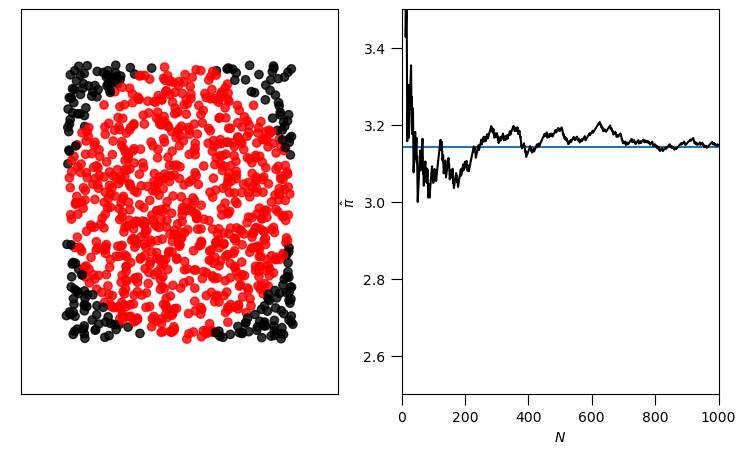

In [6]:
run_peeble = peeble_exp()
run_peeble.generate_throws()
run_peeble.plot_total()

15. How is the error between the estimator $\hat{\pi}$ and $\pi$ behaving with the number of samples $N$? Generate the error plot of 10 experiments and compare with the Buffon experiment. To do so, complete the `plot_error` routine above in `peeble_exp` and run the code below.


Generating peeble throws
hat_pi = 3.1888111888111887 for 1000 throws
Generating peeble throws
hat_pi = 3.076923076923077 for 1000 throws
Generating peeble throws
hat_pi = 3.1648351648351647 for 1000 throws
Generating peeble throws
hat_pi = 3.096903096903097 for 1000 throws
Generating peeble throws
hat_pi = 3.080919080919081 for 1000 throws
Generating peeble throws
hat_pi = 3.160839160839161 for 1000 throws
Generating peeble throws
hat_pi = 3.1248751248751248 for 1000 throws
Generating peeble throws
hat_pi = 3.144855144855145 for 1000 throws
Generating peeble throws
hat_pi = 3.132867132867133 for 1000 throws
Generating peeble throws
hat_pi = 3.212787212787213 for 1000 throws


Generating needle throws
hat_pi = 2.9729729729729732 for 1000 throws
Generating needle throws
hat_pi = 3.2038834951456314 for 1000 throws
Generating needle throws
hat_pi = 3.0414746543778803 for 1000 throws
Generating needle throws
hat_pi = 3.548387096774194 for 1000 throws
Generating needle throws
hat_pi = 2.8571

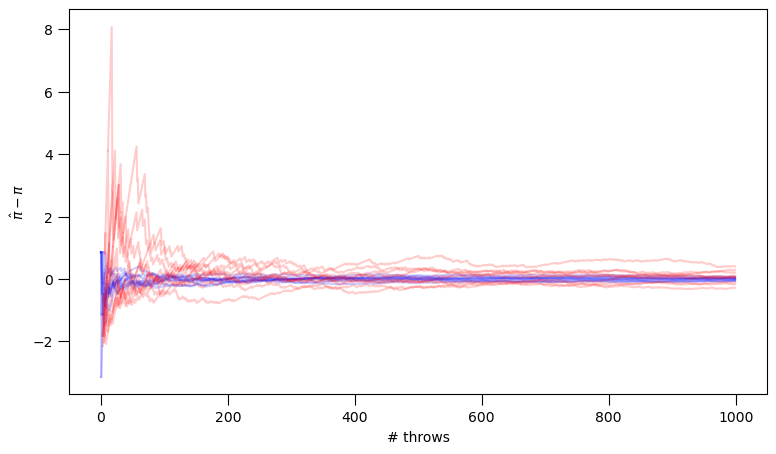

In [7]:
run_peeble = peeble_exp()
run_buffon = buffon_exp()
fig=plt.figure(figsize=(9,5))
for iter_experiment in range(10):
    run_peeble.generate_throws()
    run_peeble.plot_error(fig=fig,color='b',alpha=0.2)
    run_peeble.C=[]
    run_peeble.data=[]
print ('\n')
for iter_experiment in range(10):
    run_buffon.generate_throws()
    run_buffon.plot_error(fig=fig,color='r',alpha=0.2)
    run_buffon.C=[]
    run_buffon.data=[]
    run_buffon.start = run_buffon.N+1
plt.xlabel('# throws')
plt.ylabel(r'$\hat{\pi}-\pi$')    
plt.show()

16. Derive the variance of the estimator $\hat{\pi}$ for the peeble experiment. How does it compare to the one of the Buffon experiment? Is it consistent with the numerical experiments?


17. Could you propose a better experiment and estimator to get $\pi$? (Propose it below and compare it with the previous experiments)

### Comment

The error of this new method also converges to zero and it converges faster than the previous one. This is some experimental evidence that the estimator using peebles has lower variance than the one with the needles.

## Solution to exercises

### Exercise 16

We have that $\hat{\pi} = \frac{1}{N}\sum_{i = 1}^{N}\theta_{i}$, where $(\theta_{i})_{i\in\{1,\dots,N\}}$ are i.i.d random variables with $\theta_{1}\sim\text{Ber}(\frac{\pi}{4})$. We have therefore that $\text{Var}(\theta_{1}) = \frac{\pi}{4}(1 - \frac{\pi}{4})$ and thus:


$$
\text{Var}(\hat{\pi}) = 16\text{Var}\left( \frac{1}{N} \sum_{i = 1}^{N} \theta_{i} \right)
$$

$$
\text{Var}(\hat{\pi}) = 16\frac{N}{N^{2}} \text{Var} (\theta_{1}) 
$$

$$
\text{Var}(\hat{\pi}) = 16\frac{1}{N} \text{Var} (\theta_{1})
$$

$$
\text{Var}(\hat{\pi}) = 16 \frac{1}{N} \frac{\pi}{4}\left(1 - \frac{\pi}{4}\right)
$$

$$
\text{Var}(\hat{\pi}) = 4 \frac{\pi}{N} \left(1 - \frac{\pi}{4}\right)
$$

We now compare it to the variance obtained in the Buffon experiment:

$$
\text{Var}(\hat{\pi}_{b}) = \frac{1}{N} \left(1 - \frac{2l}{d\pi}\right) \frac{d^{3}\pi^{4}}{8 l^{3}}
$$

If we take $r = \frac{l}{d}$:

$$
\text{Var}(\hat{\pi}_{b}) = \frac{1}{N} \left(1 - \frac{2r}{\pi}\right) \frac{\pi^{4}}{8 r^{3}}
$$

$$
\text{Var}(\hat{\pi}_{b}) = \frac{1}{N} \frac{\pi}{4} \left(1 - \frac{2r}{\pi}\right) \frac{\pi^{3}}{2 r^{3}}
$$

The minimal variance is obtained when $r = 1$ as the function $r\mapsto \left(1 - \frac{2r}{\pi}\right) \frac{\pi^{3}}{2 r^{3}}$ is a decreasing function in the inverval $r\in[0,1]$. Therefore:

$$
\text{Var}(\hat{\pi}_{b}^{\star}) = \frac{1}{N} \frac{\pi}{4} \left(1 - \frac{2}{\pi}\right) \frac{\pi^{3}}{2}
$$


In [8]:
print('Numerical term for peeble experiment:', 16*(1 - np.pi/4))
print('Lowest numerical term for Buffon experiment:', (1 - 2/np.pi) * np.pi**3 / 2)

Numerical term for peeble experiment: 3.4336293856408275
Lowest numerical term for Buffon experiment: 5.63353393906055


Therefore:

$$
\text{Var}(\hat{\pi}) \approx 3.4 \frac{1}{N} \frac{\pi}{4} \quad \text{and} \quad \text{Var}(\hat{\pi}_{b}^{\star}) \approx 5.6 \frac{1}{N} \frac{\pi}{4}
$$

We see that the optimal constant factor for Buffon's experiment differs from more than 25 times the one from the peebles experiment. This result agrees with the experimental observations.

### Exercise 17



We can propose find the following integral:

$$
\int_{0}^{1} f(x)dx = \int_{0}^{1} 4\sqrt{1-x^{2}}dx = \pi
$$

By taking $n$ i.i.d random variables $(X_{i})_{i\in\mathbb{N}}$, with $X_{i} \sim U([0,1])$ and averaging the results of the random variable $f(X)$:

$$
\hat{\pi} = \frac{1}{N}\sum_{i=1}^{N} f(x_{i})
$$

As $f$ is a continous function in $[0,1]$, by the law of large numbers we should retrieve when $n\rightarrow +\infty$:

$$
\frac{1}{N}\sum_{i=1}^{N} f(x_{i}) \rightarrow \pi
$$

As for its variance:

$$
\mathbb{V}[\hat\pi] = \mathbb{V}\left[\frac{1}{N}\sum_{i=1}^{N} f(X_{i})\right] = \frac{1}{N} (\mathbb{E}[f(X)^{2}] - \mathbb{E}[f(X)]^{2})
$$

And:

$$
\mathbb{E}[f(X)] = \int_{0}^{1}4\sqrt{1-x^{2}}dx = \pi \quad \text{and} \quad \mathbb{E}[f(X)^{2}] = \int_{0}^{1}16(1-x^{2})dx = \frac{32}{3} 
$$

Donc:

$$
\mathbb{V}[\hat\pi] = \frac{1}{N}\left(\frac{32}{3}  - \pi^{2}\right)
$$

$$
\mathbb{V}[\hat\pi] = 4\frac{\pi}{N}\left(\frac{32}{12 \pi}  - \frac{\pi}{4}\right)
$$

Where previously we had:

$$
\text{Var}(\hat{\pi}_{\text{circle}}) = 4 \frac{\pi}{N} \left(1 - \frac{\pi}{4}\right)
$$

As $\frac{32}{12 \pi} < 1$ we have a lower variance for this method.

Furthermore, as seen more recently in the course, we can further improve the variance by taking $g(X) = \frac{1}{2}(f(X) + f(1-X))$ as the function, exploiting the symmetry of the uniform distribution. This would imply that we would be evaluating $f$ two more times at each iteration, but only generating one random variable $X$ at a time, that usually has a higher cost.

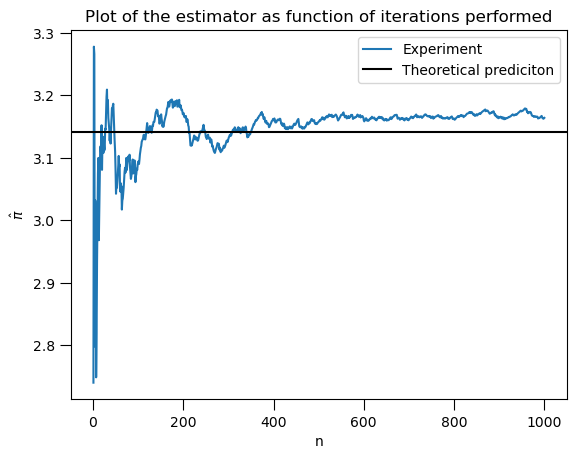

In [9]:
N = 1000

## Studied function
def func(x: float) -> float:
    return 4*np.sqrt(1-x**2)

## Generating random variables
x = np.random.uniform(0,1,N)

estimator = np.cumsum(func(x)) / np.arange(1,N+1)
Ns = np.arange(1,N+1)

plt.title("Plot of the estimator as function of iterations performed")
plt.plot(Ns, estimator, label='Experiment')
plt.axhline(np.pi, color = 'black', label = 'Theoretical prediciton')
plt.xlabel('n')
plt.ylabel(r'$\hat{\pi}$')    
plt.legend()
plt.show()

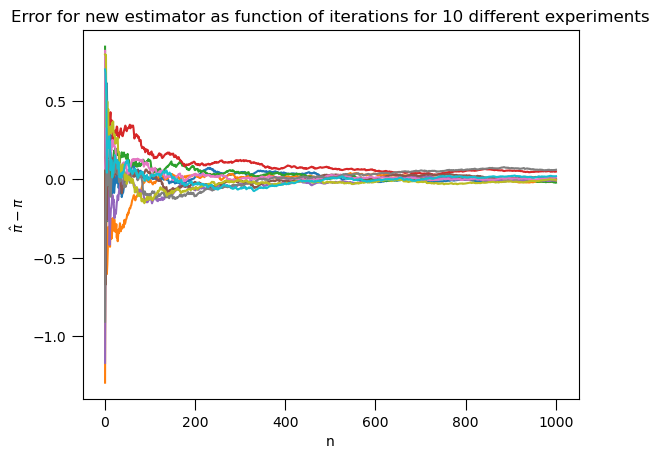

In [10]:
for i in range(10):
    x = np.random.uniform(0,1,N)

    estimator = np.cumsum(func(x)) / np.arange(1,N+1) - np.pi
    Ns = np.arange(1,N+1)
    
    plt.plot(Ns, estimator)

plt.title("Error for new estimator as function of iterations for 10 different experiments")
plt.xlabel('n')
plt.ylabel(r'$\hat{\pi}-\pi$')    
plt.show()